# PyTorch LSTM forhåpentlig vis bedre

### Imports

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from time import time

In [3]:
uio_orange = '#FEA11B'
autumn_leaves = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
autumn_leaves = autumn_leaves[-1::]
autumn_leaves_palett = ListedColormap(sns.color_palette(autumn_leaves))
breakfast_tea = ['#331C08', '#664C36', '#CCBEB1', '#FFD3AC']
breakfast_tea_palett = ListedColormap(sns.color_palette(breakfast_tea))
night_sands = ['#574A24', '#80775C', '#FAE8B4', '#CBBD93']
night_sands_palett = ListedColormap(sns.color_palette(night_sands))

colors = autumn_leaves
color_palett = autumn_leaves_palett

In [4]:
def read_dataset(filename):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    # remove outliars
    # df = df[(df['RSRP'] >= -144) & (df['RSRP'] <= -44) &
    #         (df['SINR'] >= -19.5) & (df['SINR'] <= -3) &
    #         (df['RSRQ'] >= -20) & (df['RSRQ'] <= 20)]

    # X, y = df.drop('Mode', axis=1), df['Mode']
    X, y = df[['RSRP', 'SSS_RSRP', 'campaign', 'Latitude', 'Longitude']], df['Mode']
    return X, y


# function from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ 
def create_dataset(f, t, lookback):
    curr_campaign = ''
    X, y = [], []
    for i in range(len(t) - lookback):
        feature = f[i : i + lookback]
        target = t[i + 1 : i + lookback + 1]
        if curr_campaign == '': # set new current campaign if there is np campaign
            curr_campaign = f['campaign'][i]
        if feature['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'][i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'][i]
        X.append(feature)
        y.append(target)

    return np.array(X), np.array(y)


def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f): # check to see if we are bwyond the data set
            break

        if curr_campaign == '': # set new current campaign if there is np campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)
    return np.array(X), np.array(y)


def vertical_handover(y):
    new_y = []
    for seq in y:
        if 0 in seq and 1 in seq:
            new_y.append(1)
        else:
            new_y.append(0)
    return np.array(new_y)


def count_correct_hos(y_pred, y_true):
    correct_hos = []
    for yt, yp in zip(y_true, y_pred):
        seq = []
        for i in range(len(yt)):
            if yt[i] == 1 and yp[i] == 1:
                seq.append(1)
            else:
                seq.append(0)
        correct_hos.append(seq)
    return np.array(correct_hos)


def count_hos(y):
    changed_y = []
    for seq in y:
        changed_seq = []
        for i in range(len(seq)-1):
            if seq[i] != seq[i + 1]:
                changed_seq.append(1)
            else:
                changed_seq.append(0)
        changed_y.append(changed_seq)

    return np.array(changed_y)


def accuracy_single_datapoint (y_pred, y_true):
    correct_preds = 0
    n = 0
    for yt, yp in zip(y_true, y_pred):
        correct_preds += np.sum(yt == yp)
        n += len(yp)
    return correct_preds / n

def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)


def precision_recall(y_pred, y_true):
    tp, fp, fn =  0, 0, 0

    # Loop through true and predicted labels to count TP, FP, and FN
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
        elif yt == 0 and yp == 1:
            fp += 1
        elif yt == 1 and yp == 0:
            fn += 1
    print(tp, fp, fn)

    # Precision calculation
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    # Recall calculation
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    return precision, recall

In [5]:
X, y = read_dataset('datasets/Op1_merged.csv')
n_steps_in, n_steps_out = 15, 10

X, y = series_split_sequences(X, y, n_steps_in, n_steps_out)

In [26]:
train_size = len(y) // 3 * 2
test_size = (len(y) - train_size) // 2 + train_size

X_train, y_train = X[0 : train_size], y[0 : train_size]
X_val, y_val = X[train_size : test_size], y[train_size : test_size]
X_test, y_test = X[test_size ::], y[test_size ::]
y_test_changed = vertical_handover(y_test)

n_features = X_train.shape[2]
losses, accuracies, recalls, precisions = [], [], [], []

In [7]:

# model = Sequential()
# model.add(LSTM(units=500, activation='relu',return_sequences=False, input_shape=(n_steps_in, n_features)))
# model.add(LSTM(units=500, activation='relu'))
# model.add(Dense(n_steps_out))
# model.compile(optimizer='adam', loss='mse')

# model.fit(X_train, y_train, epochs=300, verbose=0)

# y_pred = model.predict(X_test)
# y_pred = (y_pred > 0.5).astype(int)
# y_pred_changed = vertical_handover(y_pred)
# loss = model.evaluate(X_test, y_test)
# acc = accuracy(y_test_changed, y_pred_changed)
# prec, rec = precision_recall(y_pred_changed, y_test_changed)
# print(f'Loss: {loss}')
# print(f'Accuracy: {acc}')
# print(f'Percision: {prec}')
# print(f'Recall: {rec}')
# losses.append(loss)
# accuracies.append(acc)
# precisions.append(prec)
# recalls.append(rec)

# print(f'Loss Mean: {np.mean(losses):.3f}')
# print(f'Loss Standard Deviation: {np.std(losses):.3f}')
# print(f'Accuracy Mean: {np.mean(accuracies):.3f}')
# print(f'Accuracy Standard Deviation: {np.std(accuracies):.3f}')
# print(f'Precision Mean: {np.mean(precisions):.3f}')
# print(f'Precision Standard Deviation: {np.std(precisions):.3f}')
# print(f'Recall Mean: {np.mean(recalls):.3f}')
# print(f'Recall Standard Deviation: {np.std(recalls):.3f}')

In [ ]:
model = Sequential()
model.add(LSTM(input_shape=(n_steps_in, n_features), units=200,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=True, return_state=False
              ))
model.add(LSTM(units=200,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=False, return_state=False
              ))
model.add(Dense(n_steps_out, activation='softmax'))
model.compile(loss='mean_squared_error',
              metrics=['accuracy'],
              optimizer='adam')
print(model.summary())

lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=80, mode='min'
                           #restore_best_weights=True
                           )

/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 15, 200)        │       164,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,810 (1.86 MB)

 Trainable params: 486,810 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
y_train_flat = np.array([item for sublist in y_train for item in sublist])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

start = time()
History = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    class_weight=class_weight_dict)
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

-----------------------------------------------------------------
Training was completed in 1855.12 secs
-----------------------------------------------------------------


In [40]:
class_weight_dict

{0: 0.8900324677651713, 1: 1.1409722796475463}

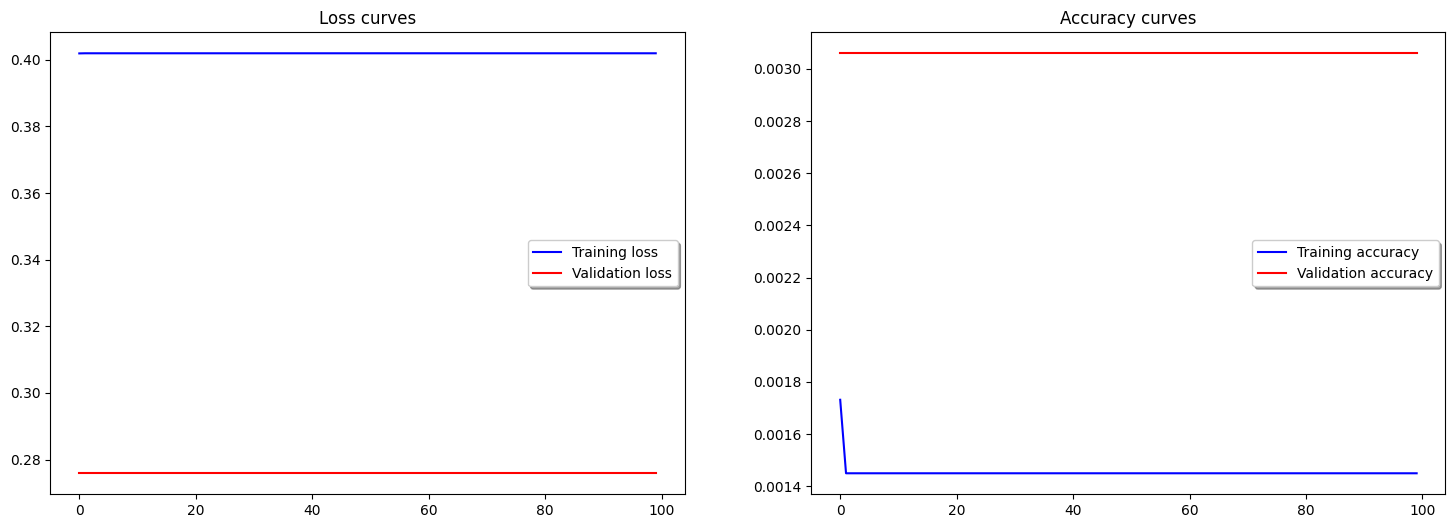

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
0.7026574327588984
168 6041 0
0.02705749718151071
0.02705749718151071 1.0
(array([0, 1]), array([55881,  6209]))


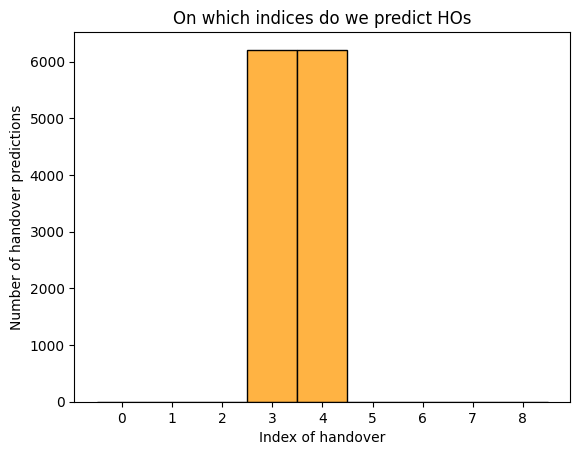

In [50]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(accuracy_single_datapoint(y_pred, y_test))
y_pred_changed = vertical_handover(y_pred)
precision, recall = precision_recall(y_pred_changed, y_test_changed)
print(accuracy(y_pred_changed, y_test_changed))
print(precision, recall)
indices_of_hos = []
y_pred_hos = count_hos(y_pred)

print(np.unique(y_pred, return_counts=True))

for seq in y_pred_hos:
    indices_of_hos.extend(np.where(seq == 1)[0])

plt.hist(indices_of_hos, bins=np.arange(y_pred_hos.shape[1] + 1) - 0.5, edgecolor='black', color=colors[0])
plt.xlabel('Index of handover')
plt.ylabel('Number of handover predictions')
plt.title('On which indices do we predict HOs')
plt.xticks(range(y_pred_hos.shape[1]))

plt.show()

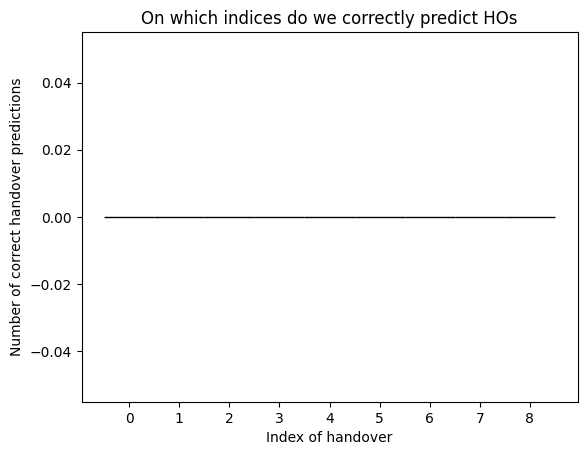

In [12]:
correct_hos = count_correct_hos(y_pred_hos, count_hos(y_test))

indices_of_correct_hos = []

for seq in correct_hos:
    indices_of_correct_hos.extend(np.where(seq == 1)[0])

plt.hist(indices_of_correct_hos, bins=np.arange(correct_hos.shape[1] + 1) - 0.5, edgecolor='black', color=colors[0])
plt.xlabel('Index of handover')
plt.ylabel('Number of correct handover predictions')
plt.title('On which indices do we correctly predict HOs')
plt.xticks(range(correct_hos.shape[1]))

plt.show()